# Fruit Ripeness Classifier with PyTorch

This notebook demonstrates how to build a fruit ripeness classifier using PyTorch, aiming for 90%+ accuracy. It includes data loading, preprocessing, model training, evaluation, analytics, and prediction demo.

In [2]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
# Section 1: Import Libraries and Load Dataset
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Paths to your data folders
train_dir = 's:/project/data/Train'
test_dir = 's:/project/data/Test'

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets and loaders
datasets_train = datasets.ImageFolder(train_dir, transform=transform)
datasets_test = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(datasets_train, batch_size=32, shuffle=True)
test_loader = DataLoader(datasets_test, batch_size=32, shuffle=False)

# Show class names
print('Classes:', datasets_train.classes)

Classes: ['Overipe', 'Ripe', 'Unripe']


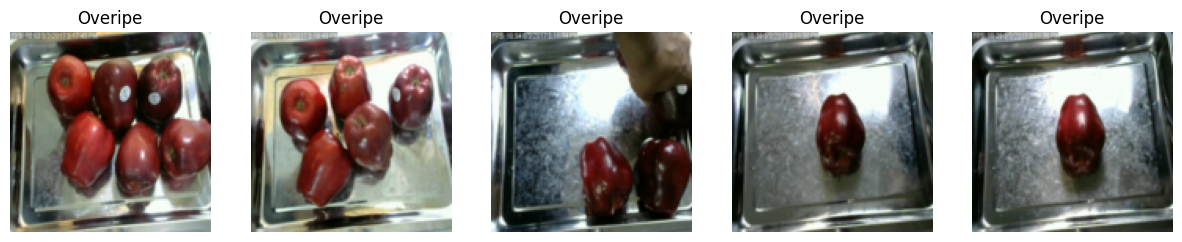

In [3]:
# Section 2: Data Visualization
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    img, label = datasets_train[i]
    img = img.permute(1,2,0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(datasets_train.classes[label])
    axes[i].axis('off')
plt.show()

In [4]:
# Section 3: Model Definition
class FruitRipenessCNN(nn.Module):
    def __init__(self, num_classes):
        super(FruitRipenessCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(datasets_train.classes)
model = FruitRipenessCNN(num_classes)


In [5]:
# Section 4: Training Setup and Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses, test_accuracies = [], []
best_acc = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_loader))
    # Evaluate on test set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    test_accuracies.append(acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_fruit_ripeness_cnn.pth')
    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Test Accuracy: {acc:.2f}%')
    if acc >= 90:
        print('Target accuracy reached!')
        break

Epoch 1, Loss: 0.5814, Test Accuracy: 66.11%
Epoch 2, Loss: 0.4303, Test Accuracy: 80.00%
Epoch 2, Loss: 0.4303, Test Accuracy: 80.00%
Epoch 3, Loss: 0.3419, Test Accuracy: 81.11%
Epoch 3, Loss: 0.3419, Test Accuracy: 81.11%
Epoch 4, Loss: 0.2630, Test Accuracy: 84.44%
Epoch 4, Loss: 0.2630, Test Accuracy: 84.44%
Epoch 5, Loss: 0.2079, Test Accuracy: 80.56%
Epoch 5, Loss: 0.2079, Test Accuracy: 80.56%
Epoch 6, Loss: 0.1627, Test Accuracy: 84.44%
Epoch 6, Loss: 0.1627, Test Accuracy: 84.44%
Epoch 7, Loss: 0.1093, Test Accuracy: 86.67%
Epoch 7, Loss: 0.1093, Test Accuracy: 86.67%
Epoch 8, Loss: 0.0858, Test Accuracy: 87.22%
Epoch 8, Loss: 0.0858, Test Accuracy: 87.22%
Epoch 9, Loss: 0.0455, Test Accuracy: 88.33%
Epoch 9, Loss: 0.0455, Test Accuracy: 88.33%
Epoch 10, Loss: 0.0756, Test Accuracy: 89.44%
Epoch 10, Loss: 0.0756, Test Accuracy: 89.44%
Epoch 11, Loss: 0.0715, Test Accuracy: 87.78%
Epoch 11, Loss: 0.0715, Test Accuracy: 87.78%
Epoch 12, Loss: 0.0413, Test Accuracy: 88.33%
Epoch

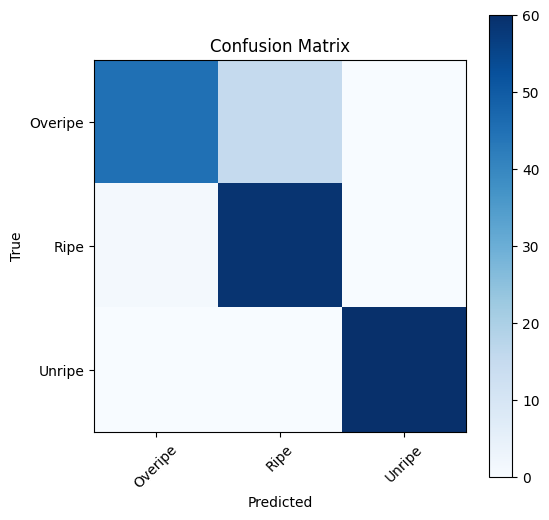

              precision    recall  f1-score   support

     Overipe       0.98      0.75      0.85        60
        Ripe       0.80      0.98      0.88        60
      Unripe       1.00      1.00      1.00        60

    accuracy                           0.91       180
   macro avg       0.93      0.91      0.91       180
weighted avg       0.93      0.91      0.91       180



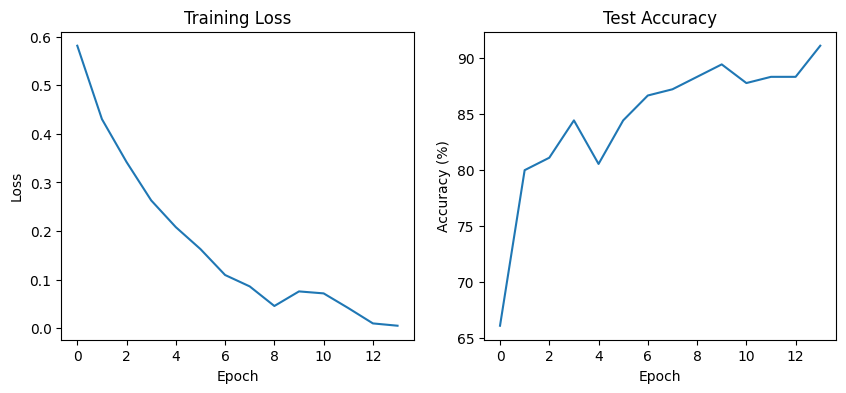

In [6]:
# Section 5: Model Evaluation and Analytics
model.load_state_dict(torch.load('best_fruit_ripeness_cnn.pth'))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes), datasets_train.classes, rotation=45)
plt.yticks(np.arange(num_classes), datasets_train.classes)
plt.colorbar()
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=datasets_train.classes))

# Plot training loss and test accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

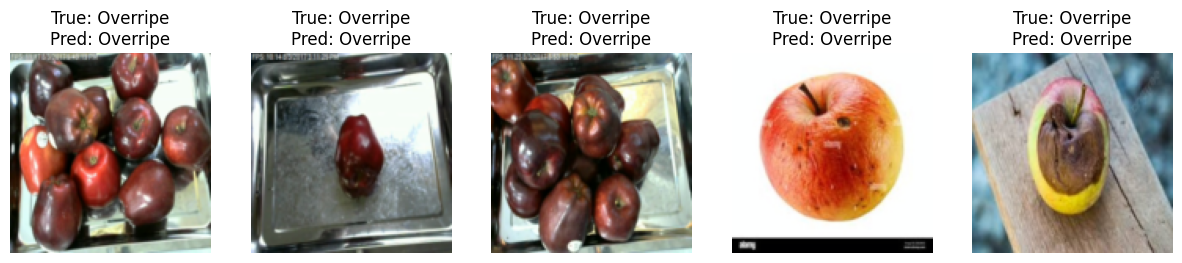

In [7]:
# Section 6: Prediction Demo
fig, axes = plt.subplots(1, 5, figsize=(15,3))
model.eval()
for i in range(5):
    img, label = datasets_test[i]
    input_img = img.unsqueeze(0)
    with torch.no_grad():
        output = model(input_img)
        _, pred = torch.max(output, 1)
    img_disp = img.permute(1,2,0).numpy()
    img_disp = img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_disp = np.clip(img_disp, 0, 1)
    axes[i].imshow(img_disp)
    axes[i].set_title(f'True: {datasets_test.classes[label]}\nPred: {datasets_test.classes[pred.item()]}')
    axes[i].axis('off')
plt.show()

In [9]:
# Section: Per-Class and Overall Accuracy
from collections import Counter

# Overall accuracy
overall_acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
print(f'Overall Accuracy: {overall_acc:.2f}%')

# Per-class accuracy
class_correct = Counter()
class_total = Counter()
for pred, label in zip(all_preds, all_labels):
    if pred == label:
        class_correct[label] += 1
    class_total[label] += 1
for idx, class_name in enumerate(datasets_train.classes):
    acc = 100 * class_correct[idx] / class_total[idx] if class_total[idx] > 0 else 0
    print(f'Accuracy for class "{class_name}": {acc:.2f}%')

Overall Accuracy: 91.11%
Accuracy for class "Overipe": 75.00%
Accuracy for class "Ripe": 98.33%
Accuracy for class "Unripe": 100.00%


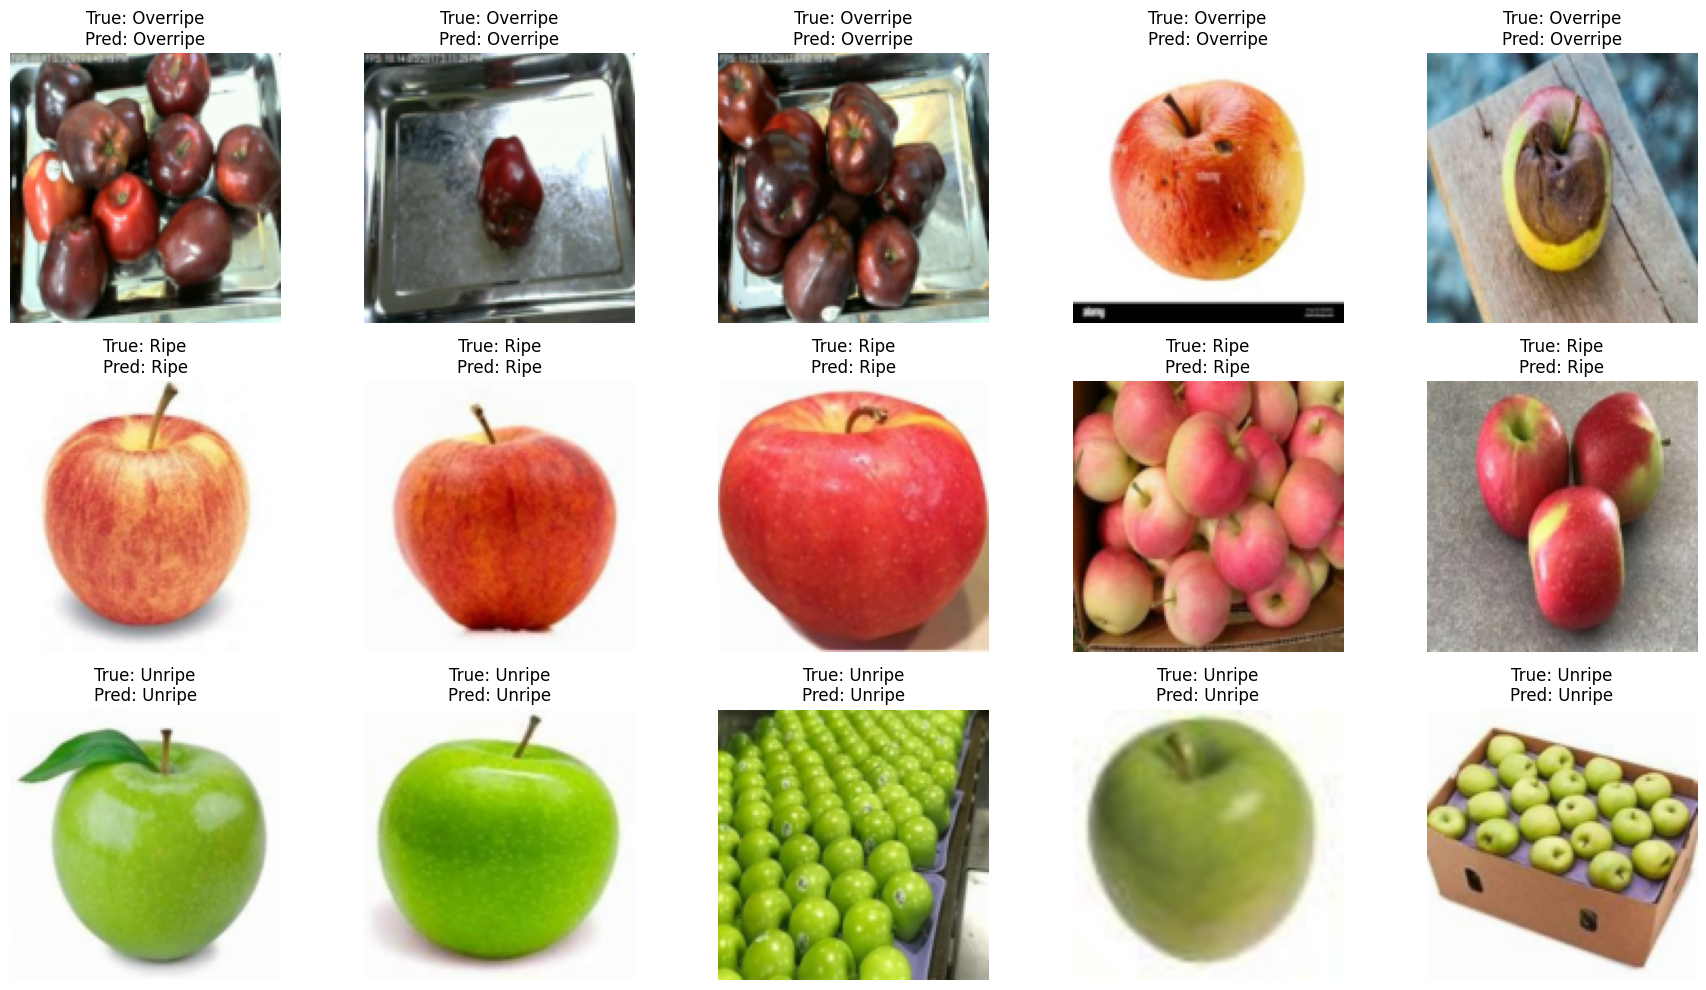

In [10]:
# Section: Test with 5 Images from Each Class
fig, axes = plt.subplots(3, 5, figsize=(18,10))
model.eval()
for class_idx, class_name in enumerate(datasets_test.classes):
    # Find indices of images for this class
    indices = [i for i, (_, label) in enumerate(datasets_test.samples) if label == class_idx]
    for j in range(5):
        img_idx = indices[j] if len(indices) > j else indices[0]
        img, label = datasets_test[img_idx]
        input_img = img.unsqueeze(0)
        with torch.no_grad():
            output = model(input_img)
            _, pred = torch.max(output, 1)
        img_disp = img.permute(1,2,0).numpy()
        img_disp = img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_disp = np.clip(img_disp, 0, 1)
        axes[class_idx, j].imshow(img_disp)
        axes[class_idx, j].set_title(f'True: {class_name}\nPred: {datasets_test.classes[pred.item()]}')
        axes[class_idx, j].axis('off')
plt.tight_layout()
plt.show()